# Interaction between two rigid bodies in a salt solution

This will simulated two rigid bodies confined on the length axis of a cylinder with hard ends. We use a continuum solvent and explicit, soft spheres for salt particles which are treated grand canonically. During simulation, the rigid bodies rotate and symmetrically translate around the center of the cylinder. Titratable sites are updated with swap moves.


### System Requirements
This Jupyter Notebook was originally run in MacOS 10.11 with `GCC 4.8`, `Python2`, `matplotlib`, `pandas` within the Anaconda environment. Contemporary Linux distributions such as Ubuntu 14.04 should work as well.

### Download and build Faunus

We use a custom Metropolis Monte Carlo (MC) program build within the [Faunus framework](http://github.com/mlund/faunus.git). The sections below will fetch the complete faunus project and compile the program.

In [1]:
from __future__ import division, unicode_literals, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
import os.path, os, sys, json, filecmp, copy
plt.rcParams.update({'font.size': 16, 'figure.figsize': [8.0, 6.0]})
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd $workdir
print(workdir)

/Users/mikael/github/faunus-notebooks/twobody


In [2]:
%%bash -s "$workdir"
cd $1

# if different, copy custom gctit.cpp into faunus
if ! cmp mc/gctit.cpp faunus/src/examples/gctit.cpp >/dev/null 2>&1
then
    cp mc/gctit.cpp faunus/src/examples/
fi

if [ ! -d "faunus/" ]; then
    git clone https://github.com/mlund/faunus.git
    cd faunus
    git checkout a0f0b46
else
    cd faunus
fi
pwd
CXX=clang++ CC=clang cmake . -DCMAKE_BUILD_TYPE=Release -DENABLE_APPROXMATH=on &>/dev/null
make example_gctit -j4

/Users/mikael/github/faunus-notebooks/twobody/faunus
[ 36%] Built target xdrfile
[ 81%] Built target libfaunus
[100%] Built target example_gctit


### Create Input and run MC simulation

In [3]:
pH_range       = [7.0]
salt_range     = [0.03] # mol/l
macroion_range = ['N20-R10.0.pqr', 'N20-R10.0-central.pqr']
dptrans_range  = [3]    # translational displacement
dprot          = 0.5    # rotational displacement

In [4]:
%cd $workdir'/mc'

def mkinput():
    js = {
        "energy": {
            "eqstate": { "processfile": "gctit.json" },
            "nonbonded": {
                "coulomb": { "epsr": 80, "ionicstrength":1e-20 },
                "ljsimple": { "eps": 0.005 }
            },
            "cmconstrain" : {
                "protein1 protein2" : { "mindist": 20, "maxdist": 30 }
            }
        },

        "system": {
            "temperature": 298.15,
            "cylinder" : { "length" : cyllength, "radius" : 35 },
            "mcloop": { "macro": 10, "micro": micro }
        },

        "moves": {
            "gctit"         : { "molecule": "salt", "prob": 0.5 },
            "moltransrot2body" : {
                "protein1" : { "dp":dptrans, "dprot":dprot }, 
                "protein2" : { "dp":dptrans, "dprot":dprot } 
            },
            "atomtranslate" : {
                "salt":  { "prob": 0.5 }
            }
        },

        "moleculelist": {
            "protein1":  { "structure":macroion, "Ninit":1, "insdir":"0 0 0", "insoffset":"0 0 -11"},
            "protein2":  { "structure":macroion, "Ninit":1, "insdir":"0 0 0", "insoffset":"0 0 11"},
            "salt": {"atoms":"Na Cl", "Ninit":60, "atomic":True }
        },

        "atomlist" : {
            "Na"   :  { "q": 1, "r":1.9, "mw":22.99, "dp":100, "activity":salt },
            "Cl"   :  { "q":-1, "r":1.7, "mw":35.45, "dp":100, "activity":salt },
            "NN"   :  { "q": 0.5,  "r":0.1, "mw":1 },
            "NF"   :  { "q": -0.5, "r":0.1, "mw":1 },
            "He"   :  { "q": 0, "r":0.5, "mw":100000 },
            "I"    :  { "q":-1, "r":2.0, "mw":1 },
            "SCN"  :  { "q":-1, "r":2.0, "mw":1 },
            "ASP"  :  { "q":-1, "r":3.6, "mw":110 },
            "HASP" :  { "q":0,  "r":3.6, "mw":110 },
            "LASP" :  { "q":2,  "r":3.6, "mw":110 },
            "CTR"  :  { "q":-1, "r":2.0, "mw":16 },
            "HCTR" :  { "q":0,  "r":2.0, "mw":16 },
            "GLU"  :  { "q":-1, "r":3.8, "mw":122 },
            "HGLU" :  { "q":0,  "r":3.8, "mw":122 },
            "LGLU" :  { "q":2,  "r":3.8, "mw":122 },
            "HIS"  :  { "q":0,  "r":3.9, "mw":130 },
            "HHIS" :  { "q":1,  "r":3.9, "mw":130 },
            "NTR"  :  { "q":0,  "r":2.0, "mw":14 },
            "HNTR" :  { "q":1,  "r":2.0, "mw":14 },
            "TYR"  :  { "q":-1, "r":4.1, "mw":154 },
            "HTYR" :  { "q":0,  "r":4.1, "mw":154 },
            "LYS"  :  { "q":0,  "r":3.7, "mw":116 },
            "HLYS" :  { "q":1,  "r":3.7, "mw":116 },
            "CYb"  :  { "q":0,  "r":3.6, "mw":103 },
            "CYS"  :  { "q":-1, "r":3.6, "mw":103 },
            "HCYS" :  { "q":0,  "r":3.6, "mw":103 },
            "ARG"  :  { "q":0,  "r":4.0, "mw":144 },
            "HARG" :  { "q":1,  "r":4.0, "mw":144 },
            "ALA"  :  { "q":0,  "r":3.1, "mw":66 },
            "ILE"  :  { "q":0,  "r":3.6, "mw":102 },
            "LEU"  :  { "q":0,  "r":3.6, "mw":102 },
            "MET"  :  { "q":0,  "r":3.8, "mw":122 },
            "PHE"  :  { "q":0,  "r":3.9, "mw":138 },
            "PRO"  :  { "q":0,  "r":3.4, "mw":90 },
            "TRP"  :  { "q":0,  "r":4.3, "mw":176 },
            "VAL"  :  { "q":0,  "r":3.4, "mw":90 },
            "SER"  :  { "q":0,  "r":3.3, "mw":82 },
            "THR"  :  { "q":0,  "r":3.5, "mw":94 },
            "ASN"  :  { "q":0,  "r":3.6, "mw":108 },
            "GLN"  :  { "q":0,  "r":3.8, "mw":120 },
            "GLY"  :  { "q":0,  "r":2.9, "mw":54 }
        },

        "processes" : {
            "H-Asp" : { "bound":"HASP" , "free":"ASP" , "pKd":4.0  , "pX":pH },
            "H-Ctr" : { "bound":"HCTR" , "free":"CTR" , "pKd":2.6  , "pX":pH },
            "H-Glu" : { "bound":"HGLU" , "free":"GLU" , "pKd":4.4  , "pX":pH },
            "H-His" : { "bound":"HHIS" , "free":"HIS" , "pKd":6.3  , "pX":pH },
            "H-Arg" : { "bound":"HARG" , "free":"ARG" , "pKd":12.0 , "pX":pH },
            "H-Ntr" : { "bound":"HNTR" , "free":"NTR" , "pKd":7.5  , "pX":pH },
            "H-Cys" : { "bound":"HCYS" , "free":"CYS" , "pKd":10.8 , "pX":pH },
            "H-Tyr" : { "bound":"HTYR" , "free":"TYR" , "pKd":9.6  , "pX":pH },
            "H-Lys" : { "bound":"HLYS" , "free":"LYS" , "pKd":10.4 , "pX":pH },
            "K1"    : { "bound":"NN", "free":"NF","pKd":7,  "pX":pH }
        }
    }

    with open('gctit.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))

for dptrans in dptrans_range:
    if dptrans==0:
        cyllength=100
    else:
        cyllength=150
        
    for pH in pH_range:
        for salt in salt_range:
            for macroion in macroion_range:
                pfx='pH'+str(pH)+'-I'+str(salt)+'-'+macroion+'-dptrans'+str(dptrans)
                macroion='../'+macroion
                if not os.path.isdir(pfx):
                    %mkdir -p $pfx 
                    %cd $pfx
                    # equilibration run (no translation)
                    !rm -fR state
                    micro=50 * cyllength
                    null=0
                    dptrans, null = null, dptrans
                    mkinput()
                    dptrans, null = null, dptrans
                    !../../faunus/src/examples/gctit > eq
                    
                    # production run
                    micro=2000 * cyllength
                    mkinput()
                    %time !../../faunus/src/examples/gctit > out
                    %cd ..
%cd ..
print('done.')

/Users/mikael/github/faunus-notebooks/twobody/mc
/Users/mikael/github/faunus-notebooks/twobody
done.


### Potential of mean force

/Users/mikael/github/faunus-notebooks/twobody/mc
/Users/mikael/github/faunus-notebooks/twobody/mc/pH7.0-I0.03-N20-R10.0.pqr-dptrans3
/Users/mikael/github/faunus-notebooks/twobody/mc
/Users/mikael/github/faunus-notebooks/twobody/mc/pH7.0-I0.03-N20-R10.0-central.pqr-dptrans3
/Users/mikael/github/faunus-notebooks/twobody/mc


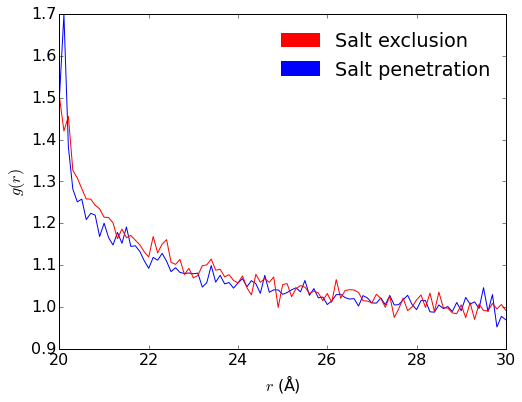

In [5]:
%cd $workdir'/mc'
dptrans=3
for pH in pH_range:
    for salt in salt_range:
        for macroion in macroion_range:
            if 'central' in macroion:
                color='r'
            else:
                color='b'
            pfx='pH'+str(pH)+'-I'+str(salt)+'-'+macroion+'-dptrans'+str(dptrans)
            if os.path.isdir(pfx):
                %cd $pfx
                r, P = np.loadtxt("rdf.dat", unpack=True)
                P = P / P[ (r>28) ].mean() # normalize to unity at long sep.
                plt.plot(r, P, label=str(salt), c=color)
                %cd ..

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='r', label='Salt exclusion')
blue_patch = mpatches.Patch(color='b', label='Salt penetration')

plt.legend(loc=0, frameon=False, handles=[red_patch, blue_patch])
plt.xlabel(r'$r$ (Å)')
plt.ylabel(r'$g(r)$')
#plt.ylim( (0, 20) )
#plt.xlim( (0, 20) )
plt.savefig('fig.pdf', bbox_inches='tight')

### Plot macro-ion charge as a function of salt concentration for fixed separation (no macro-ion translation)

/Users/mikael/github/faunus-notebooks/twobody/mc


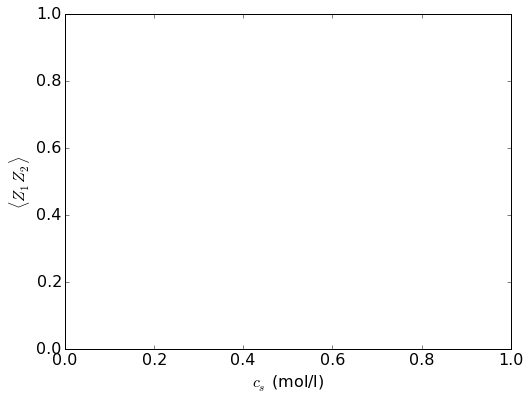

In [7]:
%cd $workdir'/mc'

# extract data into dict
data={}
dptrans=0
for macroion in macroion_range:
    data[macroion]=[]
    for pH in pH_range:
        for salt in salt_range:
            pfx='pH'+str(pH)+'-I'+str(salt)+'-'+macroion+'-dptrans'+str(dptrans)
            if os.path.isdir(pfx):
                name=pfx+'/out'
                Z = !cat {name} | grep -C 7 ' Multipole' | tail -n 1 | gawk '{{print $$2}}'
                Z = float(Z[0])
                C = !cat {name} | grep -C 7 ' Multipole' | tail -n 1 | gawk '{{print $$3}}'
                C = float(C[0])
                corr = !cat {name} | grep "Charge product"
                corr = float(corr.s.split()[-1])
                
                qq = !cat {name} | grep "Avg. charge"
                q1 = float(qq.s.split()[-3])
                q2 = float(qq.s.split()[-2])
                qq = float(qq.s.split()[-1])
                print(q1, q2, qq, q1*q2-qq, corr)
                data[macroion].append( [salt, qq] )

# plot
for macroion in macroion_range:
    if 'central' in macroion:
        color='r'
    else:
        color='b'

    for d in data[macroion]:
        plt.scatter(d[0], d[1], c=color, s=60)

#plt.ylabel(r'$\langle Z_1\rangle \langle Z_2 \rangle - \langle Z_1Z_2\rangle$')
plt.ylabel(r'$\langle Z_1Z_2\rangle$')
plt.xlabel(r'$c_s$ (mol/l)')